In [12]:
import sys
import os

# Add the path to your 'scripts' directory
scripts_dir = os.path.abspath('../scripts')
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)
# Import necessary functions from the module
from query_data import fetch_data
from data_cleaning import check_missing_values, drop_na_in_columns, check_missing_values_columns,find_duplicates
from overview_eda import get_top_manufacturers,get_top_manufacturers,get_top_handsets_per_manufacturer,get_top_handsets_by_type
# Import functions from the user behavior analysis module
from user_behavior_analysis import aggregate_user_behaviour, get_skewness, get_kurtosis, plot_box_plots, plot_violin_plots, plot_correlation_matrix, perform_pca, perform_pca_multiple_components
from data_base_cl import DB_Client

In [5]:
# Step 2: Define your SQL query
query = "SELECT * FROM xdr_data LIMIT 10;"  # Update the table name if needed

# Step 3: Fetch the data from PostgreSQL
data = fetch_data(query)

# Step 4: Check if the data is fetched successfully and display the first few rows
if data is not None:
    print("Data fetched successfully!")
    print(data.head())  # Display the first 5 rows of the data
else:
    print("No data fetched.")
    

Data fetched successfully.
Data fetched successfully!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L

## 1) Data Cleaning

In [13]:
# obtain values form environment variables
host = os.getenv("DB_HOST")
user_name = os.getenv("DB_USER")
passowrd = os.getenv("DB_PASSWORD")
port = os.getenv("DB_PORT")
database = os.getenv("DB_NAME")
db_client = DB_Client(
    host=host,
    user_name=user_name,
    password=passowrd,
    port=port,
    database_name=database
)

data = db_client.dump_data()

d:\Desktop\Tellco-Profitability-Analysis\scripts\data_base_cl.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  response = pd.read_sql_query(sql=query, con=self.connection)


In [14]:
data.describe()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
count,1.490100e+05,150000.000000,150000.000000,1.500000e+05,1.494310e+05,1.489350e+05,1.494290e+05,122172.000000,122189.000000,150000.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500000e+05,1.500000e+05
mean,1.013887e+19,499.188200,498.800880,1.046086e+05,2.082016e+14,4.188282e+10,4.847455e+13,109.795706,17.662883,13300.045927,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,4.112121e+07,4.546434e+08
std,2.893173e+18,288.611834,288.097653,8.103762e+04,2.148809e+10,2.447443e+12,2.241637e+13,619.782739,84.793524,23971.878541,...,6.710569e+06,6.345423e+06,6.725218e+06,6.359490e+06,2.439675e+08,4.782700e+06,2.432050e+08,4.769004e+06,1.127639e+07,2.441429e+08
min,6.917538e+18,0.000000,0.000000,7.142000e+03,2.040471e+14,3.360100e+10,4.400152e+11,0.000000,0.000000,0.000000,...,5.300000e+01,1.050000e+02,4.200000e+01,3.500000e+01,2.516000e+03,5.900000e+01,3.290000e+03,1.480000e+02,2.866892e+06,7.114041e+06
25%,7.349883e+18,250.000000,251.000000,5.744050e+04,2.082014e+14,3.365130e+10,3.546071e+13,32.000000,2.000000,43.000000,...,5.833501e+06,5.517965e+06,5.777156e+06,5.475981e+06,2.104733e+08,4.128476e+06,2.101869e+08,4.145943e+06,3.322201e+07,2.431068e+08
50%,7.349883e+18,499.000000,500.000000,8.639900e+04,2.082015e+14,3.366371e+10,3.572201e+13,45.000000,5.000000,63.000000,...,1.161602e+07,1.101345e+07,1.164222e+07,1.099638e+07,4.234081e+08,8.291208e+06,4.218030e+08,8.267071e+06,4.114331e+07,4.558411e+08
75%,1.304243e+19,749.000000,750.000000,1.324302e+05,2.082018e+14,3.368349e+10,8.611970e+13,70.000000,15.000000,19710.750000,...,1.744852e+07,1.651556e+07,1.747048e+07,1.650727e+07,6.331742e+08,1.243162e+07,6.316918e+08,1.238415e+07,4.903424e+07,6.657055e+08
max,1.318654e+19,999.000000,999.000000,1.859336e+06,2.140743e+14,8.823971e+14,9.900120e+13,96923.000000,7120.000000,378160.000000,...,2.325910e+07,2.201196e+07,2.325919e+07,2.201196e+07,8.434419e+08,1.655879e+07,8.434425e+08,1.655882e+07,7.833131e+07,9.029696e+08


In [15]:
data.isna().mean()

Bearer Id                                   0.006607
Start                                       0.000007
Start ms                                    0.000007
End                                         0.000007
End ms                                      0.000007
Dur. (ms)                                   0.000007
IMSI                                        0.003800
MSISDN/Number                               0.007107
IMEI                                        0.003813
Last Location Name                          0.007687
Avg RTT DL (ms)                             0.185525
Avg RTT UL (ms)                             0.185412
Avg Bearer TP DL (kbps)                     0.000007
Avg Bearer TP UL (kbps)                     0.000007
TCP DL Retrans. Vol (Bytes)                 0.587636
TCP UL Retrans. Vol (Bytes)                 0.644322
DL TP < 50 Kbps (%)                         0.005027
50 Kbps < DL TP < 250 Kbps (%)              0.005027
250 Kbps < DL TP < 1 Mbps (%)               0.

### What the Data Indicates
Columns with No Missing Values:
Columns like Bearer Id, Start, End, Total UL (Bytes), etc., have 0.0 as their missing value proportion, meaning there are no missing values in these columns.

Columns with Partial Missing Values:
Some columns have a proportion of missing values:

Avg RTT DL (ms) and Avg RTT UL (ms) have 0.5, meaning 50% of their data is missing.
TCP DL Retrans. Vol (Bytes) has 0.8, indicating 80% of its values are missing.
TCP UL Retrans. Vol (Bytes) has 0.9, meaning 90% of its data is missing.

In [16]:
columns_of_interest = ["Handset Type", "Handset Manufacturer", "Bearer Id", "Start", "Start ms", "End", "End ms", "Dur. (ms)", "Dur. (ms).1"]
data[columns_of_interest].isna().mean()

Handset Type            0.003813
Handset Manufacturer    0.003813
Bearer Id               0.006607
Start                   0.000007
Start ms                0.000007
End                     0.000007
End ms                  0.000007
Dur. (ms)               0.000007
Dur. (ms).1             0.000007
dtype: float64

#### Ive decided to drop missing values

In [17]:
# look for na values in columns except for 'Handset Manufacturer' and 'Bearer Id' and drop the row if it has one na
data.dropna(subset=columns_of_interest, inplace=True)

In [18]:
# Find duplicate rows
duplicate_data = find_duplicates(data)
print("Duplicate rows in the data:\n", duplicate_data)

Duplicate rows in the data:
 Empty DataFrame
Columns: [Bearer Id, Start, Start ms, End, End ms, Dur. (ms), IMSI, MSISDN/Number, IMEI, Last Location Name, Avg RTT DL (ms), Avg RTT UL (ms), Avg Bearer TP DL (kbps), Avg Bearer TP UL (kbps), TCP DL Retrans. Vol (Bytes), TCP UL Retrans. Vol (Bytes), DL TP < 50 Kbps (%), 50 Kbps < DL TP < 250 Kbps (%), 250 Kbps < DL TP < 1 Mbps (%), DL TP > 1 Mbps (%), UL TP < 10 Kbps (%), 10 Kbps < UL TP < 50 Kbps (%), 50 Kbps < UL TP < 300 Kbps (%), UL TP > 300 Kbps (%), HTTP DL (Bytes), HTTP UL (Bytes), Activity Duration DL (ms), Activity Duration UL (ms), Dur. (ms).1, Handset Manufacturer, Handset Type, Nb of sec with 125000B < Vol DL, Nb of sec with 1250B < Vol UL < 6250B, Nb of sec with 31250B < Vol DL < 125000B, Nb of sec with 37500B < Vol UL, Nb of sec with 6250B < Vol DL < 31250B, Nb of sec with 6250B < Vol UL < 37500B, Nb of sec with Vol DL < 6250B, Nb of sec with Vol UL < 1250B, Social Media DL (Bytes), Social Media UL (Bytes), Google DL (Bytes), 

The output above indicates that no duplicate rows were found in the dataset. The check for duplicate entries across all 55 columns returned an empty DataFrame, signifying that each row in the dataset is unique. This ensures the data is consistent and free from redundancy, making it suitable for analysis

## 2) Exploratory Data Analysis

In [19]:
# Step 1: Get the top 10 handsets used by customers
top_handsets = get_top_handsets_by_type(data)
print("Top 10 Handsets by User Count:\n", top_handsets)

Top 10 Handsets by User Count:
                       Handset Type  User Count
315               Huawei B528S-23A       19752
53         Apple iPhone 6S (A1688)        9401
49          Apple iPhone 6 (A1586)        9004
1392                     undefined        8960
59          Apple iPhone 7 (A1778)        6301
73         Apple iPhone Se (A1723)        5176
66          Apple iPhone 8 (A1905)        4985
78         Apple iPhone Xr (A2105)        4562
953   Samsung Galaxy S8 (Sm-G950F)        4504
75          Apple iPhone X (A1901)        3809


### Top 10 Handsets by User Count

The table above shows the **top 10 handsets** based on the number of users. Here's a brief overview:

- **Huawei B528S-23A** leads with a significant **19,752** users, making it the most popular handset in this dataset.
- **Apple iPhone models** dominate the list, with the **iPhone 6S (A1688)** and **iPhone 6 (A1586)** having **9,401** and **9,004** users, respectively.
- The entry marked as **"undefined"** indicates missing or unidentified handset data, accounting for **8,960** entries.
- Other notable handsets include the **iPhone 7 (A1778)** with **6,301** users and the **Samsung Galaxy S8 (Sm-G950F)** with **4,504** users.

Overall, we can observe a strong preference for both **Apple iPhones** and **Samsung devices**, with a significant number of undefined entries that may require further data validation.


In [20]:
# Step 3: Get the top 5 handsets per top 3 manufacturers
top_handsets_per_manufacturer = get_top_handsets_per_manufacturer(data)
print("Top 5 Handsets per Manufacturer:\n", top_handsets_per_manufacturer)

Top 5 Handsets per Manufacturer:
    Handset Manufacturer                    Handset Type  Count
0                 Apple         Apple iPhone 6S (A1688)   9401
1                 Apple          Apple iPhone 6 (A1586)   9004
2                 Apple          Apple iPhone 7 (A1778)   6301
3                 Apple         Apple iPhone Se (A1723)   5176
4                 Apple          Apple iPhone 8 (A1905)   4985
5                Huawei                Huawei B528S-23A  19752
6                Huawei                    Huawei E5180   2079
7                Huawei  Huawei P20 Lite Huawei Nova 3E   2015
8                Huawei                      Huawei P20   1476
9                Huawei                  Huawei Y6 2018    996
10              Samsung    Samsung Galaxy S8 (Sm-G950F)   4504
11              Samsung      Samsung Galaxy A5 Sm-A520F   3716
12              Samsung     Samsung Galaxy J5 (Sm-J530)   3689
13              Samsung     Samsung Galaxy J3 (Sm-J330)   3476
14              Samsu

### Top 5 Handsets per Manufacturer

The table above provides the **top handsets per manufacturer** based on the user count. Below is a summary of the results:

#### Apple
- **Apple iPhone 6S (A1688)** takes the lead with **9,401** users, making it the most popular Apple handset in this dataset.
- **Apple iPhone 6 (A1586)** follows closely with **9,004** users, showcasing the strong presence of older iPhone models.
- Other top iPhones include the **iPhone 7 (A1778)** with **6,301** users, the **iPhone Se (A1723)** with **5,176** users, and the **iPhone 8 (A1905)** with **4,985** users.

#### Huawei
- **Huawei B528S-23A** stands out with an impressive **19,752** users, significantly outpacing all other Huawei models.
- **Huawei E5180** and **Huawei P20 Lite (Huawei Nova 3E)** follow with **2,079** and **2,015** users, respectively, reflecting Huawei's diverse offerings.
- The **Huawei P20** and **Huawei Y6 2018** have **1,476** and **996** users, respectively, completing the list of top handsets for Huawei.

#### Samsung
- **Samsung Galaxy S8 (Sm-G950F)** leads with **4,504** users, making it the top Samsung model in this dataset.
- Other popular Samsung handsets include the **Galaxy A5 (Sm-A520F)** with **3,716** users, the **Galaxy J5 (Sm-J530)** with **3,689** users, the **Galaxy J3 (Sm-J330)** with **3,476** users, and the **Galaxy S7 (Sm-G930X)** with **3,194** users.

In summary, **Apple** continues to dominate the smartphone market with its popular iPhone models, while **Huawei** has a standout model with the **B528S-23A**. **Samsung** follows with a variety of models catering to different user preferences.



In [21]:
# Step 1: Aggregate user behavior data
user_behaviour = aggregate_user_behaviour(data)
print(user_behaviour.describe())

       num xDr Sessions  Session Duration      Total DL      Total UL  \
count     106878.000000      1.068780e+05  1.068780e+05  1.068780e+05   
mean           1.394104      1.463387e+05  6.338797e+08  5.732851e+07   
std            0.806695      1.865570e+05  4.647958e+08  3.568185e+07   
min            1.000000      7.142000e+03  8.827082e+06  2.866892e+06   
25%            1.000000      7.164225e+04  3.149780e+08  3.639906e+07   
50%            1.000000      1.028310e+05  5.703787e+08  4.679721e+07   
75%            2.000000      1.727990e+05  8.074872e+08  6.576010e+07   
max           18.000000      1.855375e+07  8.156743e+09  7.295774e+08   

          Volume DL     Volume UL  Social Media DL (Bytes)  \
count  1.068780e+05  1.068780e+05             1.068780e+05   
mean   7.329814e+07  2.064574e+06             2.502726e+06   
std    8.266354e+08  1.906684e+07             1.889041e+06   
min    0.000000e+00  0.000000e+00             1.200000e+01   
25%    0.000000e+00  0.000000e+0

### Insights from the Output:

- **User Activity**: The `xDr Sessions` variable shows that most users have between 1 to 2 sessions, with a few users having many more.
- **Data Usage**: The `Total DL` and `Total UL` values highlight the amount of data consumed and uploaded by users over time. For example, the average total download (`Total DL`) is around 633 million bytes.
- **Session Length**: The session duration varies widely, with some sessions being very short (as low as 7,142 seconds), while others are extremely long (up to 18 million seconds).
- **Social Media & Google Data**: The data on social media and Google usage (both for download and upload) indicates that some users consume a large amount of data from these platforms, with significant variability.

### Summary:

This output provides an overview of user activity and data usage patterns across several metrics. It is useful for identifying trends in how users interact with the platform (session lengths, data usage, and social media activity) and helps to understand the distribution of these behaviors in the dataset.


In [38]:
# Step 2: Get skewness of the data
skewness = get_skewness(user_behaviour)
print("Skewness:\n", skewness)

Skewness:
 num xDr Sessions                NaN
Session Duration           1.038742
Total DL                  -0.736903
Total UL                   0.070891
Volume DL                  1.797722
Volume UL                  1.566956
Social Media DL (Bytes)    0.420407
Social Media UL (Bytes)   -0.307153
Google DL (Bytes)         -0.227403
Google UL (Bytes)         -0.158030
Email DL (Bytes)          -0.168129
Email UL (Bytes)           0.710397
Youtube DL (Bytes)        -0.932895
Youtube UL (Bytes)        -0.156502
Netflix DL (Bytes)         0.009936
Netflix UL (Bytes)         0.302899
Gaming DL (Bytes)         -0.712924
Gaming UL (Bytes)         -0.059455
Other DL (Bytes)          -0.308175
Other UL (Bytes)          -0.472885
Volume Total               1.700899
dtype: float64


d:\Desktop\Tellco-Profitability-Analysis\scripts\user_behavior_analysis.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = df.apply(lambda x: skew(x.dropna()), axis=0)


### Skewness of the Data

The skewness values represent the asymmetry of the data distribution for each variable in the dataset. Here's what the output indicates:

1. **Positive Skewness**:
   - Variables such as `Session Duration`, `Volume DL`, `Volume UL`, and `Volume Total` have positive skewness values. This indicates that the distribution for these variables is right-skewed, meaning there are more smaller values, but a few large values pull the distribution to the right.

2. **Negative Skewness**:
   - Variables like `Total DL`, `Social Media UL (Bytes)`, and `Youtube DL (Bytes)` have negative skewness values. This means these variables are left-skewed, with more values on the higher end, and a few smaller values pulling the distribution to the left.

3. **Near Zero Skewness**:
   - Some variables, such as `Google DL (Bytes)` and `Google UL (Bytes)`, have skewness values close to zero, indicating a relatively symmetric distribution of values.



### Summary

The skewness values give insight into the distribution of the data. Positive values indicate right-skewed data, negative values indicate left-skewed data, and values near zero suggest a symmetric distribution. The presence of precision loss warnings suggests that some features in the dataset might not be well-distributed, potentially affecting the reliability of the skewness calculation.


In [22]:
# Step 3: Get kurtosis of the data
kurt = get_kurtosis(user_behaviour)
print("Kurtosis:\n", kurt)


Kurtosis:
 num xDr Sessions             20.703952
Session Duration           1232.380013
Total DL                     10.670183
Total UL                     16.573246
Volume DL                  2687.801472
Volume UL                  4308.886242
Social Media DL (Bytes)      11.315316
Social Media UL (Bytes)       9.522447
Google DL (Bytes)            10.015340
Google UL (Bytes)             9.495837
Email DL (Bytes)             10.462630
Email UL (Bytes)              9.858719
Youtube DL (Bytes)           10.003978
Youtube UL (Bytes)           10.451110
Netflix DL (Bytes)            9.231822
Netflix UL (Bytes)            9.405741
Gaming DL (Bytes)             9.854603
Gaming UL (Bytes)             9.300559
Other DL (Bytes)              8.808698
Other UL (Bytes)              9.601807
Volume Total               2654.751570
dtype: float64


### High Kurtosis Values:
- Variables like `Volume DL`, `Volume UL`, `Volume Total`, `xDr Sessions`, and `Session Duration` have extremely high kurtosis values (in the thousands, such as 2687.8 for `Volume DL` and 1232.38 for `Session Duration`).
- This indicates that these variables have very heavy tails, meaning that there are a significant number of extreme values far from the mean.
- These extreme values could be indicative of users with high data usage or long sessions compared to the majority.

### Moderate Kurtosis Values:
- Other variables like `Total DL`, `Total UL`, `Social Media DL (Bytes)`, and `Google DL (Bytes)` show moderately high kurtosis values (ranging between 8 and 16).
- This indicates that while the data has some extreme values, they are not as extreme as the variables with very high kurtosis.

### Interpretation of High Kurtosis:
- The high kurtosis values suggest that there are certain users with significantly higher data usage or session durations than most of the population, which could be outliers or power users.
- This could be useful for identifying rare but highly influential data points in our analysis (such as users consuming vast amounts of data or engaging in very long sessions).

### Summary:
- The kurtosis values indicate that several variables in the dataset have heavy tails, meaning there are a few extreme values that are significantly different from the rest of the data. These high kurtosis values highlight the presence of outliers or highly active users that could skew the overall behavior of the user base.


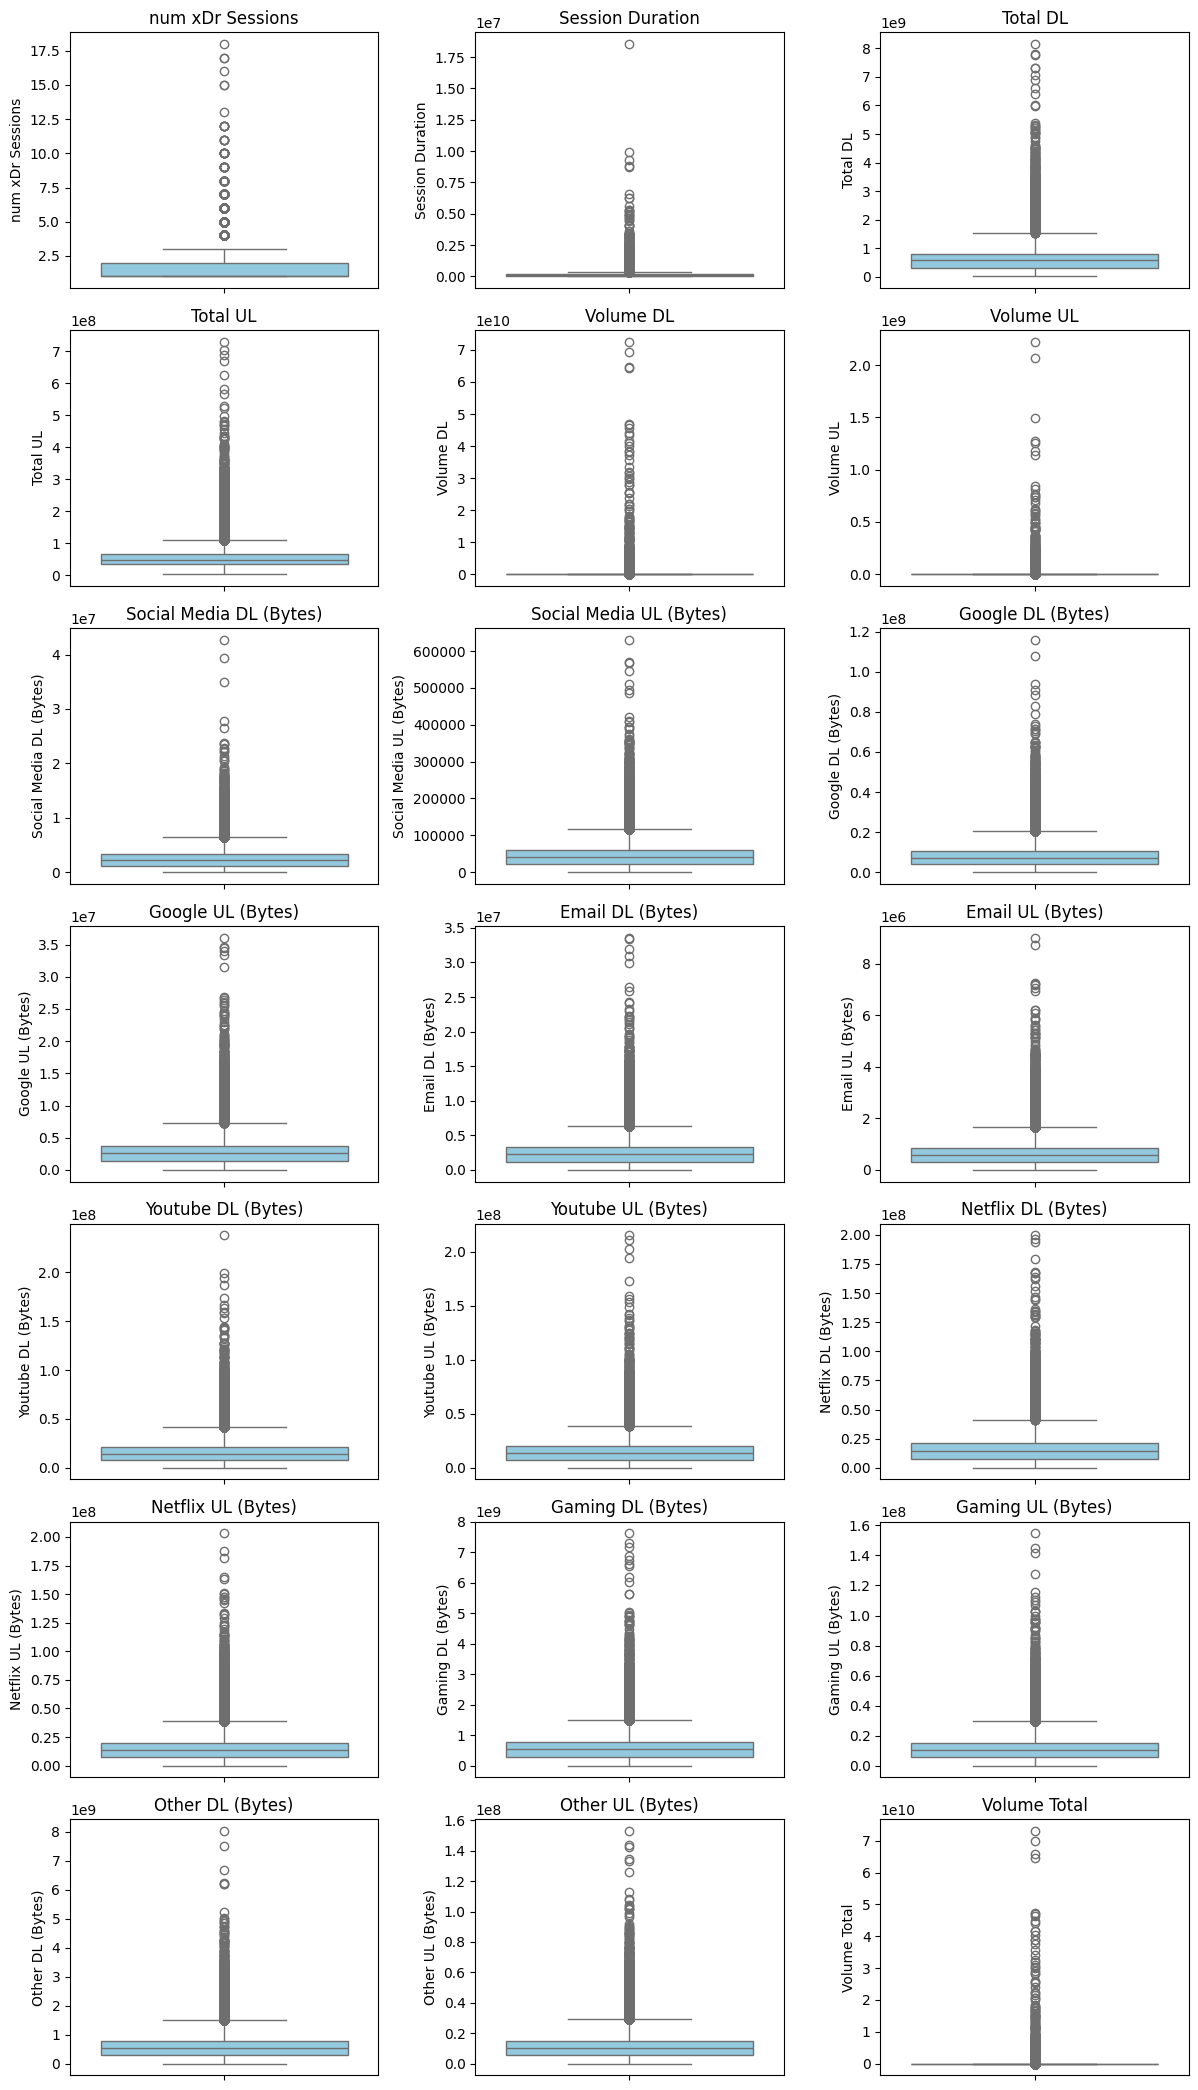

In [23]:
# Step 4: Create box plots
plot_box_plots(user_behaviour)

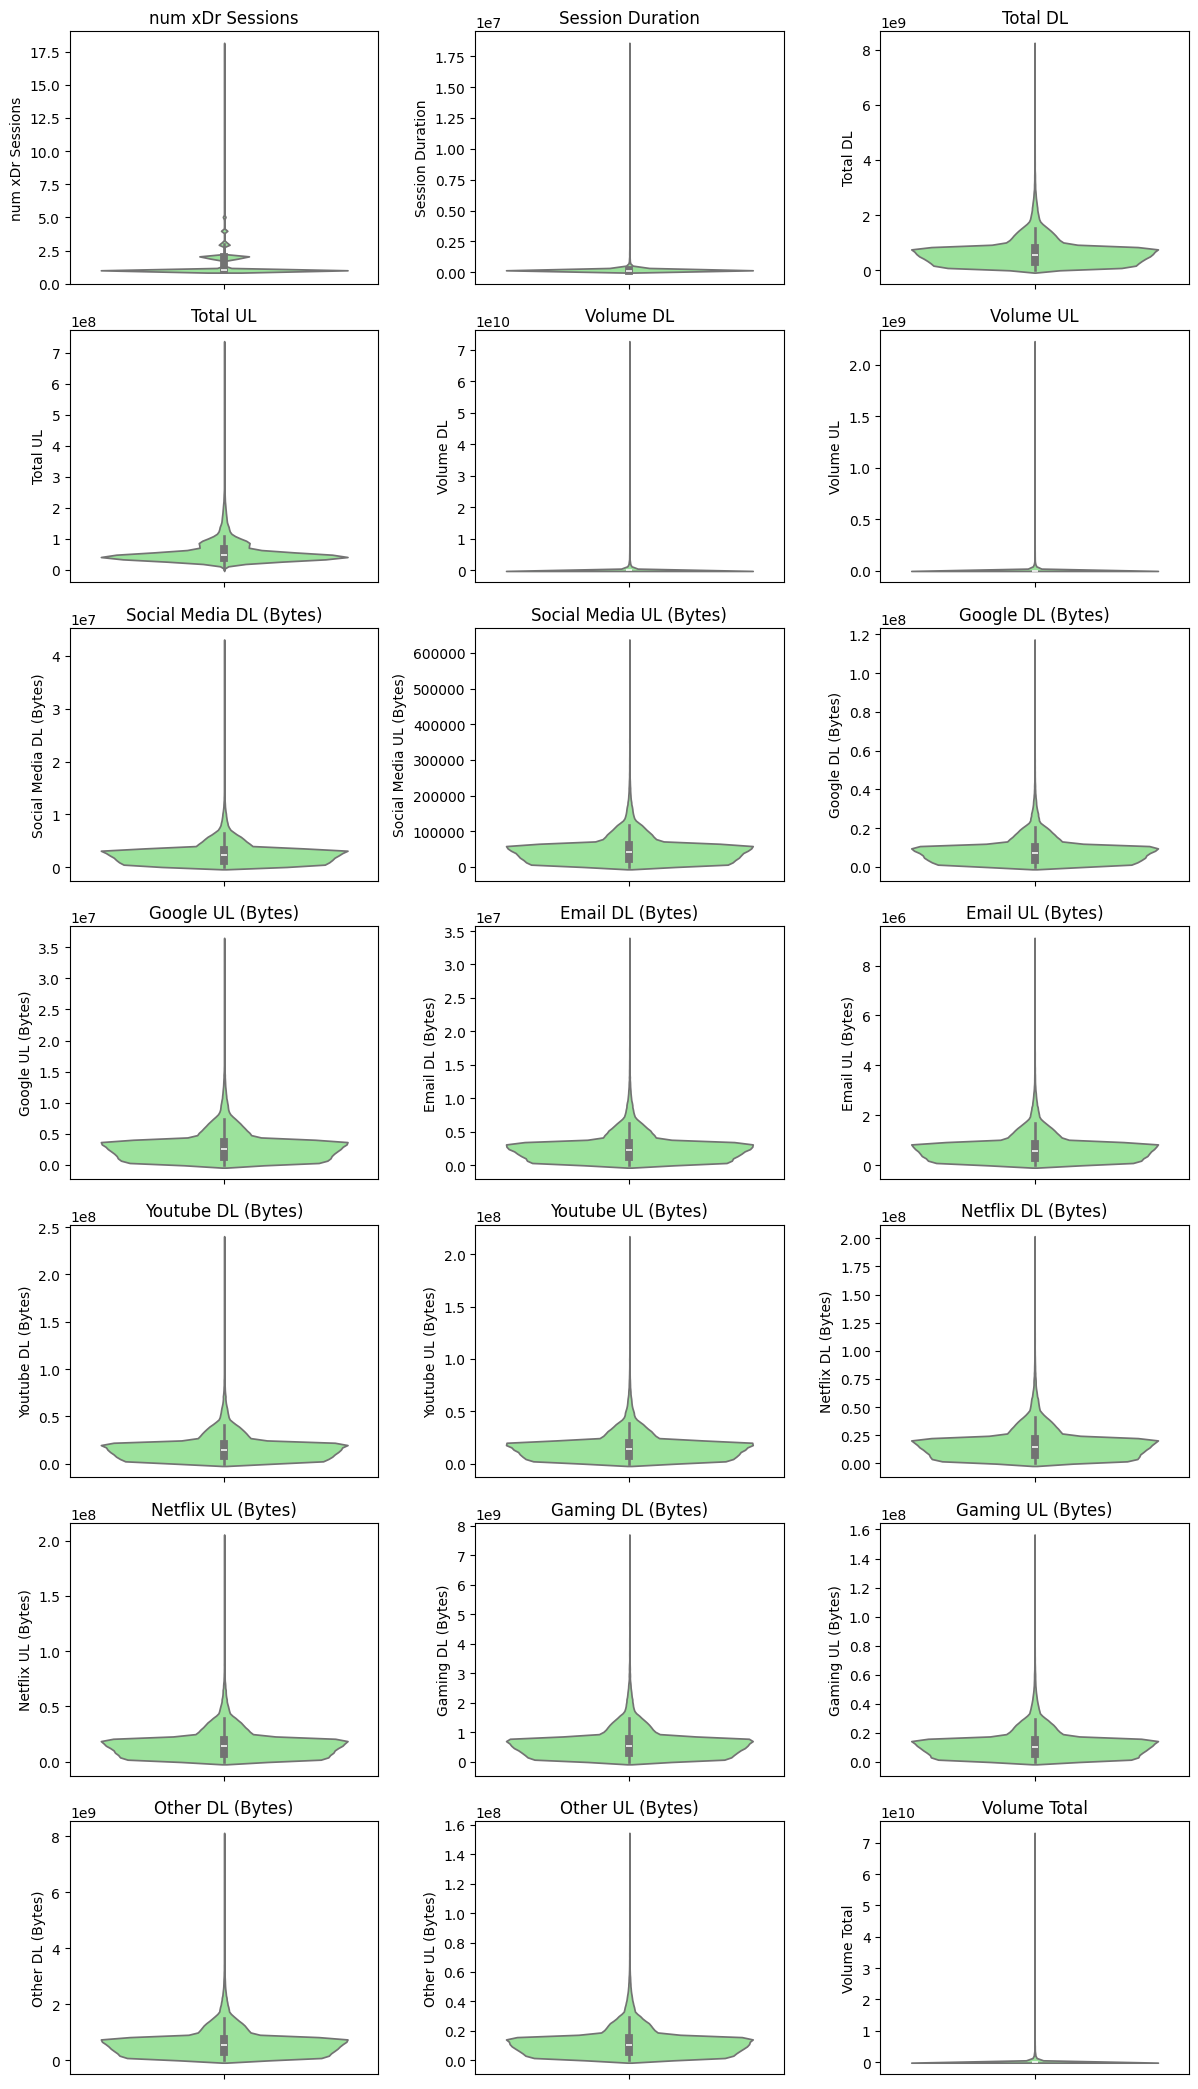

In [24]:
# Step 5: Create violin plots
plot_violin_plots(user_behaviour)

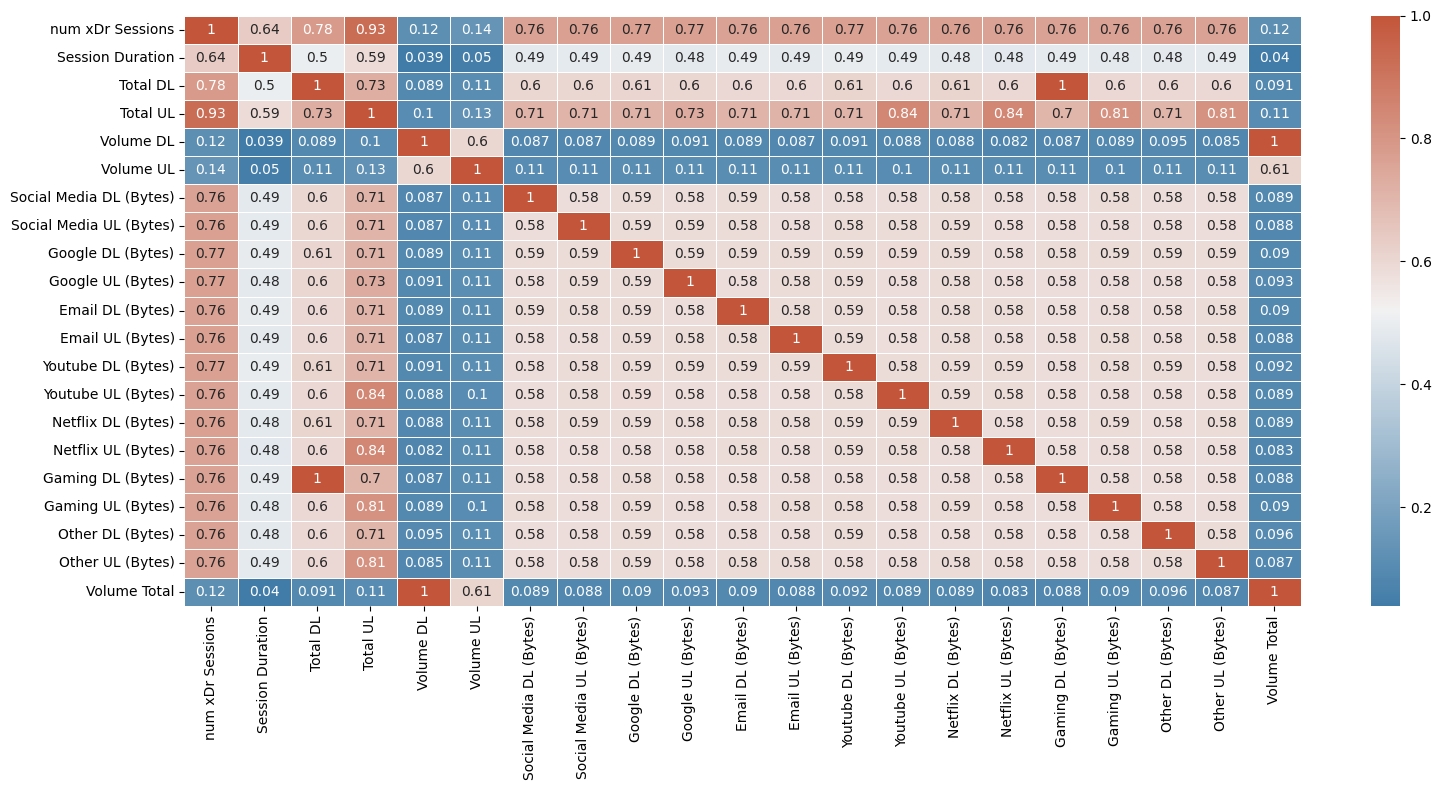

In [25]:
# Step 6: Plot correlation matrix
plot_correlation_matrix(user_behaviour)

### Key Insights from the Correlation Matrix:

1. **Number of Sessions and Applications:**
   - The number of sessions is highly correlated with all applications, with a correlation value of 0.76 for most of them.
   - The correlation is slightly higher for Google and YouTube, with a value of 0.77, indicating a slightly stronger relationship.
   - This suggests that social media activity plays a significant role in driving the frequency of user sessions, with Google and YouTube leading in this aspect. Users tend to register more sessions when using these platforms, likely due to the nature of searching and video watching.

2. **Total Upload Data:**
   - Total upload data shows a very strong correlation with YouTube (0.84), Netflix (0.84), and gaming (0.81).
   - This implies that users upload significantly more data while engaging with these activities, which could be due to interactions like video uploads, streaming, or gaming-related uploads.

3. **Total Download Data:**
   - Total download data has an exceptionally strong correlation with gaming-related downloads, with a perfect correlation of 1.
   - This indicates that a large portion of user sessions is dedicated to downloading games, and these games tend to be large in size, contributing heavily to the total data usage.

### Summary:
- Social media apps (particularly Google and YouTube) are key drivers of session frequency, while gaming and video streaming platforms like YouTube and Netflix dominate upload activity.
- The perfect correlation between total download data and gaming-related downloads suggests that gaming content is a major contributor to download traffic, likely due to the large file sizes of games.


In [26]:
# Step 7: Perform PCA and get explained variance
pca_df, explained_variance = perform_pca(user_behaviour, n_components=4)
print(f"Explained Variance (4 components): {explained_variance}")

Explained Variance (4 components): [0.5513037  0.11627121 0.03661878 0.02818862]


### Interpretation:

- **Majority of the variance** is captured by the first principal component, indicating that the majority of the structure in the data can be explained by a single dimension.
- **Subsequent components** capture smaller portions of the variance, meaning they describe increasingly less important or more nuanced variations in the data.
  
In practice, this suggests that reducing the data to just the first few principal components (such as 4 in this case) can still retain a significant portion of the original data's variance, making **PCA** a useful technique for **dimensionality reduction**.


In [27]:
# Step 8: Perform PCA with more components
pca_df_10, explained_variance_10 = perform_pca_multiple_components(user_behaviour, n_components=10)

print(f"Explained Variance (12 components): {explained_variance_10}")

Explained Variance (12 components): [0.5513037  0.11627121 0.03661878 0.02818862 0.02411414 0.02352293
 0.0202089  0.02006234 0.02003261 0.01995259]


### Explained Variance for PCA with 10 Components

The output shows the explained variance for each of the first 10 principal components after performing PCA. Here's the interpretation:

- **First Principal Component (0.5513)**: The first component captures the largest portion of the variance, accounting for approximately 55.13% of the total variance in the data.
- **Subsequent Components**: The explained variance for the remaining components decreases significantly. For example:
  - The second component captures 11.63% of the variance.
  - The third component captures 3.66%.
  - The subsequent components capture progressively smaller portions, such as around 2% for components 4 through 10.

### Interpretation:

This indicates that after the first few components, the added components contribute less and less to explaining the variance in the data. While 10 components are used, most of the important information is captured by the first few. Reducing the dimensionality to a small number of components (such as 4 or 5) can still retain most of the variance, but using more components (like 10 in this case) provides a more granular breakdown of the data's variance.
